# **Test generation of random equations**

In [30]:
from src.datagen import Equations
import jax.numpy as jnp
import cloudpickle
import hashlib
import os
import json
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots

## Define what is necessary for the generation of equations

Let's define the non linearities first, with their symbolic representations

In [31]:
non_lins = ((jnp.sin),
            (jnp.cos))


non_lin_syms = [r"\sin", r"\cos"]

Now we define as a dictionary the quantities number of variables, the maximum number of addends and so on...

In [32]:
config = {
    "n_vars": 3,
    "n_eqs": 3,
    "max_addends": 3,
    "max_multiplicands": 2,
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "seed": 42
}

Here is the definition of two functions that help us creating unique names for the systems of equations based on their configuration's values

In [33]:
def filter_config(config):
    """Filter and convert the configuration into a deterministic, serializable format."""
    filtered_config = {}
    for key, value in config.items():
        if isinstance(value, tuple):  # Convert tuples of functions to names
            filtered_config[key] = tuple(v.__name__ if callable(v) else v for v in value)
        elif callable(value):  # Replace single functions with their name
            filtered_config[key] = value.__name__
        elif isinstance(value, dict):  # Recursively process nested dictionaries
            filtered_config[key] = filter_config(value)
        else:
            filtered_config[key] = value
    return filtered_config

def get_unique_name_from_config(config):
    # Filter out non-deterministic or non-serializable elements
    filtered_config = filter_config(config)
    
    # Convert the filtered dictionary to a JSON string with sorted keys
    config_string = json.dumps(filtered_config, sort_keys=True)
    
    # Generate a hash from the string representation
    config_hash = hashlib.md5(config_string.encode()).hexdigest()
    
    # Use the hash to create a unique filename
    filename = f"dataset_{config_hash}"
    return filename

Here we can see a brief example of what happens when we ask for a filename

In [34]:
first_filename = get_unique_name_from_config(config)
print(first_filename)

dataset_19c013bbbd907fa647a81cb9162a936e


If we change the configuration, for example by setting a different non linearity, the name will be different

In [35]:
non_lins = ((jnp.tan),
            (jnp.cos))


config = {
    "n_vars": 3,
    "n_eqs": 3,
    "max_addends": 3,
    "max_multiplicands": 2,
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "seed": 42
}

second_filename = get_unique_name_from_config(config)
print(first_filename, second_filename)

dataset_19c013bbbd907fa647a81cb9162a936e dataset_c9f826c27303d74dc8e1a96957800be0


And going back to the original configuration we go back to the previous name

In [36]:
non_lins = ((jnp.sin),
            (jnp.cos))


config = {
    "n_vars": 3,
    "n_eqs": 3,
    "max_addends": 3,
    "max_multiplicands": 2,
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "seed": 42
}

third_filename = get_unique_name_from_config(config)
print(first_filename, third_filename)

dataset_19c013bbbd907fa647a81cb9162a936e dataset_19c013bbbd907fa647a81cb9162a936e


This is done because if we end up setting the same configuration of an existing system, we can autmatically check if it already exists, and then reading it instead of generating it, thus saving us time

## Generate the equations

In [37]:
save_dir = "Data"

if os.path.exists(os.path.join(save_dir, first_filename+'.pkl')):
    print("System already exists")
    with open(os.path.join(save_dir, first_filename+'.pkl'), 'rb') as f:
        system = cloudpickle.load(f)
else:
    # Save the system variable to a file
    with open(os.path.join(save_dir, first_filename+'.pkl'), 'wb') as f:
        system = Equations(**config)
        cloudpickle.dump(system, f)
    print(f"System saved as {first_filename}.pkl in directory {save_dir}")

System saved as dataset_19c013bbbd907fa647a81cb9162a936e.pkl in directory Data


We can then generate the symbolic expression of the equations using the function `save_symb_expr()`

In [38]:
system.save_symb_expr(filename=os.path.join(save_dir, first_filename+'_symbolic.pdf'))

<Figure size 350x262.5 with 0 Axes>

It is obviously possible to solve the system using the integrator that you prefer, we can use for example the function `solve_ivp` from scipy

In [ ]:
time_interval = [0, 1]
t_eval = jnp.linspace(time_interval[0], time_interval[1], int(1e5)) 
initial_conditions = [0.1, 0.5, 1]
integration_method = 'BDF'

sol = solve_ivp(system, time_interval, initial_conditions, integration_method, t_eval=t_eval)
print(sol.y)

[[0.1        0.10002148 0.10004297 ... 1.52803401 1.5280446  1.5280552 ]
 [0.5        0.50000932 0.50001864 ... 0.77806333 0.77805888 0.77805443]
 [1.         1.00000927 1.00001855 ... 2.5162576  2.51626931 2.51628103]]
100000


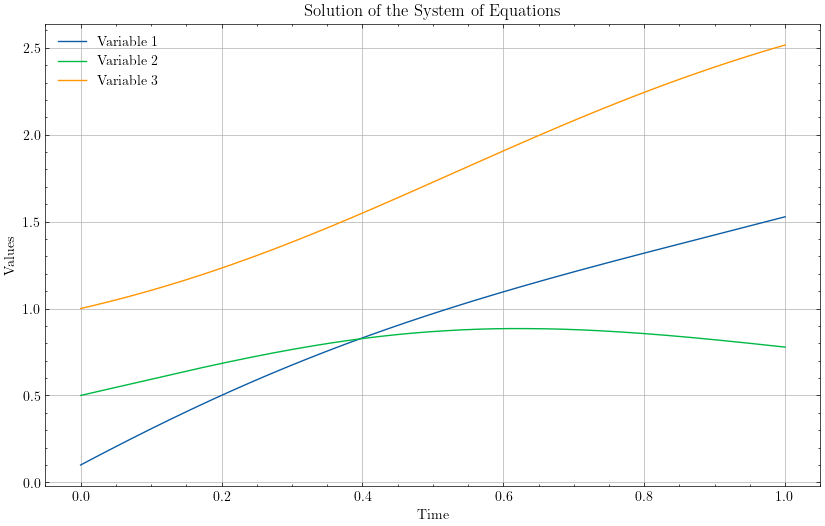

In [88]:
plt.style.use('science')

time_points = sol.t
solution = sol.y

plt.figure(figsize=(10, 6))
for i in range(solution.shape[0]):
    plt.plot(time_points, solution[i], label=f'Variable {i+1}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Equations')
plt.legend()
plt.grid(True)
plt.show()

I noticed that if we used different integrators the final value reached by each integrator is macroscopicallly different between each other. Is it a problem of my code or is it a problem of different integrators in general?

In [79]:
sol_BDF = solve_ivp(system, time_interval, initial_conditions, 'BDF')
sol_RK45 = solve_ivp(system, time_interval, initial_conditions, 'RK45')
sol_RK23 = solve_ivp(system, time_interval, initial_conditions, 'RK23')
sol_Radau = solve_ivp(system, time_interval, initial_conditions, 'Radau')

In [80]:
last_values_BDF = sol_BDF.y[:, -1]
last_values_RK45 = sol_RK45.y[:, -1]
last_values_RK23 = sol_RK23.y[:, -1]
last_values_Radau = sol_Radau.y[:, -1]

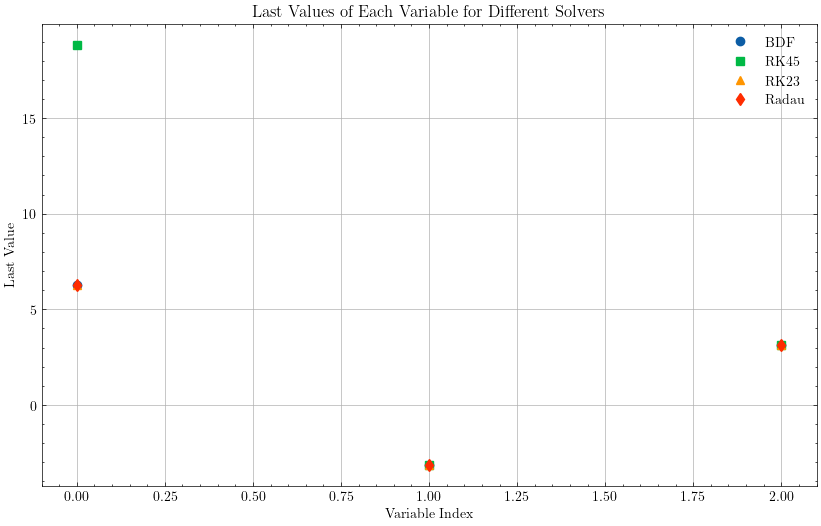

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(last_values_BDF, 'o', label='BDF')
plt.plot(last_values_RK45, 's', label='RK45')
plt.plot(last_values_RK23, '^', label='RK23')
plt.plot(last_values_Radau, 'd', label='Radau')
plt.xlabel('Variable Index')
plt.ylabel('Last Value')
plt.title('Last Values of Each Variable for Different Solvers')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
variable_1 = jnp.array((last_values_BDF[0], last_values_RK45[0], last_values_RK23[0], last_values_Radau[0]))
variable_2 = jnp.array((last_values_BDF[1], last_values_RK45[1], last_values_RK23[1], last_values_Radau[1]))
variable_3 = jnp.array((last_values_BDF[2], last_values_RK45[2], last_values_RK23[2], last_values_Radau[2]))

print(jnp.std(variable_1), jnp.std(variable_2), jnp.std(variable_3))

5.4335055 0.001185061 3.3717478e-07
